In [1]:
import sys
sys.path.append('..')
from model import Model, UnetModel
import torch
from PIL import Image
import numpy as np
from process_data import (
    train_preprocess,
    val_preprocess,
    get_augmentations,
    get_data_loader,
)

In [2]:
# model = Model()
# model.load_state_dict(torch.load("../model.pth"))

class Args:
    def __init__(self):
        self.batch_size = 1
        self.num_workers = 1
        self.data_path = "../data/CityScapes"
        
args = Args()

In [3]:
# Get dataloaders
train_loader, val_loader = get_data_loader(
    args=args, batch_size=2, num_workers=1, validation_size=0.1
)

In [4]:
# Sample a batch of images
train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))

In [5]:
# Check properties of both train and val batch
print("Train batch:")
print(train_batch[0].shape)
print(train_batch[1].shape)
print(train_batch[0].dtype)
print(train_batch[1].dtype)

print("Val batch:")
print(val_batch[0].shape)
print(val_batch[1].shape)
print(val_batch[0].dtype)
print(val_batch[1].dtype)

# Also get min max values of the images
print("Train batch min max:")
print(train_batch[0].min())
print(train_batch[0].max())

print("Val batch min max:")
print(val_batch[0].min())
print(val_batch[0].max())


Train batch:
torch.Size([2, 3, 256, 256])
torch.Size([2, 1, 256, 256])
torch.float32
torch.uint8
Val batch:
torch.Size([2, 3, 256, 256])
torch.Size([2, 1, 256, 256])
torch.float32
torch.uint8
Train batch min max:
tensor(0.0471)
tensor(1.)
Val batch min max:
tensor(0.0314)
tensor(1.)


In [14]:
model = UnetModel()
model.load_state_dict(torch.load("../model_0296.pth"))

<All keys matched successfully>

In [15]:
print(val_batch[0].shape)

torch.Size([2, 3, 256, 256])


In [16]:
# Make a prediction with the model
model.eval()
with torch.no_grad():
    prediction = model(val_batch[0])

In [17]:
print(prediction.shape)
print(prediction[0].shape)

torch.Size([2, 20, 256, 256])
torch.Size([20, 256, 256])


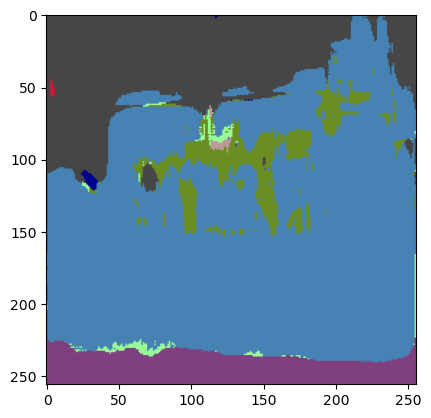

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as T
from PIL import Image

# Define the Cityscapes color map
cityscapes_color_map = {
    0: [128, 64, 128],  # road
    1: [244, 35, 232],  # sidewalk
    2: [70, 70, 70],  # building
    3: [102, 102, 156],  # wall
    4: [190, 153, 153],  # fence
    5: [153, 153, 153],  # pole
    6: [250, 170, 30],  # traffic light
    7: [220, 220, 0],  # traffic sign
    8: [107, 142, 35],  # vegetation
    9: [152, 251, 152],  # terrain
    10: [70, 130, 180],  # sky
    11: [220, 20, 60],  # person
    12: [255, 0, 0],  # rider
    13: [0, 0, 142],  # car
    14: [0, 0, 70],  # truck
    15: [0, 60, 100],  # bus
    16: [0, 80, 100],  # train
    17: [0, 0, 230],  # motorcycle
    18: [119, 11, 32],  # bicycle
    19: [0, 0, 0],  # background
}


def apply_color_map(prediction, color_map):
    # Initialize an empty RGB image
    colored_mask = np.zeros(
        (prediction.shape[0], prediction.shape[1], 3), dtype=np.uint8
    )

    # Apply the color map
    for label, color in color_map.items():
        colored_mask[prediction == label] = color

    return colored_mask


# Load an image
image_path = ("../data/CityScapes/leftImg8bit/train/aachen/aachen_000022_000019_leftImg8bit.png"
)
image = Image.open(image_path)



# Preprocess the image
preprocess = T.Compose(
    [
        T.Resize((256, 256)),
        T.ToTensor(),
        T.ToDtype(torch.float),
    ]
)
input_image = preprocess(image).unsqueeze(0)

# Pass the image through the model
model.eval()
with torch.no_grad():
    output = model(input_image)

# Postprocess the output
_, predicted_mask = torch.max(output, dim=1)

# Apply the color map to the prediction
colored_prediction = apply_color_map(
    predicted_mask.squeeze().cpu().numpy(), cityscapes_color_map
)

# Convert to image
colored_prediction = Image.fromarray(colored_prediction)

plt.imshow(colored_prediction)
